In [1]:
import pandas as pd
import numpy as np
import collections
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import scipy.spatial
import tensorflow as tf
import tensorflow_hub as hub
import scipy.spatial
#point to the Universal sentence encoder saved model folder, download from https://tfhub.dev/google/universal-sentence-encoder/4
embed = hub.load("/home/varun/ihg/ner_pipeline_ml/data/4")
lemmatizer = WordNetLemmatizer()

### I took this small dataset from analytics vidhya, lets have look at the data

In [2]:
df = pd.read_csv("./tennis_articles_v4.csv")

In [3]:
df.head()

,article_id,article_text,source
0,1,Maria Sharapova has basically no friends as te...,https://www.tennisworldusa.org/tennis/news/Mar...
1,2,"BASEL, Switzerland (AP), Roger Federer advance...",http://www.tennis.com/pro-game/2018/10/copil-s...
2,3,Roger Federer has revealed that organisers of ...,https://scroll.in/field/899938/tennis-roger-fe...
3,4,Kei Nishikori will try to end his long losing ...,http://www.tennis.com/pro-game/2018/10/nishiko...
4,5,"Federer, 37, first broke through on tour over ...",https://www.express.co.uk/sport/tennis/1036101...


In [4]:
df["article_text"][1]

"BASEL, Switzerland (AP), Roger Federer advanced to the 14th Swiss Indoors final of his career by beating seventh-seeded Daniil Medvedev 6-1, 6-4 on Saturday. Seeking a ninth title at his hometown event, and a 99th overall, Federer will play 93th-ranked Marius Copil on Sunday. Federer dominated the 20th-ranked Medvedev and had his first match-point chance to break serve again at 5-1. He then dropped his serve to love, and let another match point slip in Medvedev's next service game by netting a backhand. He clinched on his fourth chance when Medvedev netted from the baseline. Copil upset expectations of a Federer final against Alexander Zverev in a 6-3, 6-7 (6), 6-4 win over the fifth-ranked German in the earlier semifinal. The Romanian aims for a first title after arriving at Basel without a career win over a top-10 opponent. Copil has two after also beating No. 6 Marin Cilic in the second round. Copil fired 26 aces past Zverev and never dropped serve, clinching after 2 1/2 hours with

In [5]:
sentences = []
for s in df['article_text']:
    sentences.append(sent_tokenize(s))
sentences = [y for x in sentences for y in x] # flatten list

In [6]:
"""
We have 119 sentences lets try and summarize them
"""
len(sentences)

119

### There can be a ton of preprocessing techniques that i could have used to clean data but I am planning on using Universal sentence encoder, so in interest of having cotext intact i am not removing any stopwords

In [7]:
#lets create similarity matrix
sim_mat = np.zeros([len(sentences), len(sentences)])

In [8]:
"""
creating a similarty matrix
"""
for i in range(len(sentences)):
    for j in range(len(sentences)):
        v1,v2 = embed([sentences[i],sentences[j]])
        v1 = v1.numpy()
        v2 = v2.numpy()
        sim_mat[i][j] = 1 - scipy.spatial.distance.cosine(v1, v2)
"""
After this we count the similarity scores of each sentences with all
other sentences and sort them according to the scores. Idea behind doing this is 
Our top scored sentence is similar to most of the sentences that means out of all the
sentences this sentence has the info which belong to many other sentences also.
"""

'\nAfter this we count the similarity scores of each sentences with all\nother sentences and sort them according to the scores. Idea behind doing this is \nOur top scored sentence is similar to most of the sentences that means out of all the\nsentences this sentence has the info which belong to many other sentences also.\n'

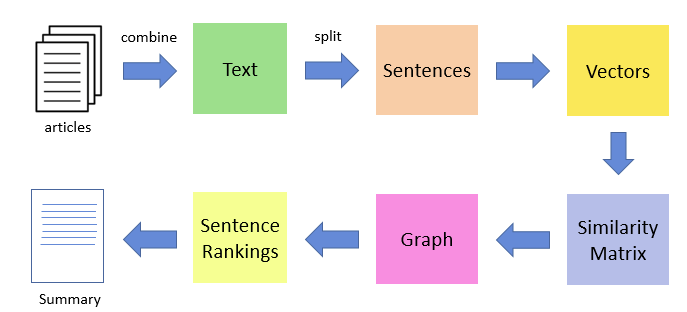

In [9]:
"""
Imgage taken from https://cdn.analyticsvidhya.com/wp-content/uploads/2018/10/block_3.png
"""
from IPython.display import Image
Image(filename='test.png') 

In [10]:
import networkx as nx

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
for i in range(3):
    print(ranked_sentences[i][1])

Federer had an easier time than in his only previous match against Medvedev, a three-setter at Shanghai two weeks ago.
Federer said earlier this month in Shanghai in that his chances of playing the Davis Cup were all but non-existent.
Nadal's appearance in Paris is a big boost to the tournament organisers who could see Roger Federer withdraw.


In [11]:
"""
Lets put all of them into one function
"""
def get_top_x(l,text):
#     print(text)
    sentences = []
    sentences.append(sent_tokenize(text))
    sentences = sentences[0]
#     print(sentences)
    sim_mat = np.zeros([len(sentences), len(sentences)])
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            v1,v2 = embed([sentences[i],sentences[j]])
            v1 = v1.numpy()
            v2 = v2.numpy()
            sim_mat[i][j] = 1 - scipy.spatial.distance.cosine(v1, v2)
    nx_graph = nx.from_numpy_array(sim_mat)
    scores = nx.pagerank(nx_graph)
    ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
    s = ""
    if l < len(ranked_sentences):
        for i in range(l):
            s = s + " " + ranked_sentences[i][1]
        return s
    else:
        return(ranked_sentences)

In [12]:
text = """Credit risk is the risk that arises from the possibility of non-payment of loans by the borrowers. Although credit risk is largely defined as risk of not receiving payments, banks also include the risk of delayed payments within this category. Often times these cash flow risks are caused by the borrower becoming insolvent. Hence, such risk can be avoided if the bank conducts a thorough check and sanctions loans only to individuals and businesses that are not likely to run out of income over the period of the loan. Credit rating agencies provide adequate information to enable the banks to make informed decisions in this regard. The profitability of a bank is extremely sensitive to credit risks. Hence, even if credit risk rises by a small amount, the profitability of the bank can get extremely impacted. Therefore, to deal with such risks banks have come up with a wide variety of measures. For instance, banks always hold a certain amount of funds in reserves to mitigate such risks. Unpaid loans were, are and will always be a byproduct of conducting the banking business. Modern banks have realized this and are prepared to handle the situation without becoming insolvent until a catastrophic loss occurs."""

In [13]:
get_top_x(3,text)

' Credit risk is the risk that arises from the possibility of non-payment of loans by the borrowers. Hence, such risk can be avoided if the bank conducts a thorough check and sanctions loans only to individuals and businesses that are not likely to run out of income over the period of the loan. Hence, even if credit risk rises by a small amount, the profitability of the bank can get extremely impacted.'